# Computing a Gradient from a Movie Poster

I had this idea for a while, of taking a movie poster, and finding a color gradient that would fit very well with it. It would be something used on, say, the details page of a streaming service for that movie. I got the idea from the poster of Thor: Ragnarok, which had a distinctive gradient look to it, although I think it could work for other posters. I'll have to see the limits of it with this notebook.

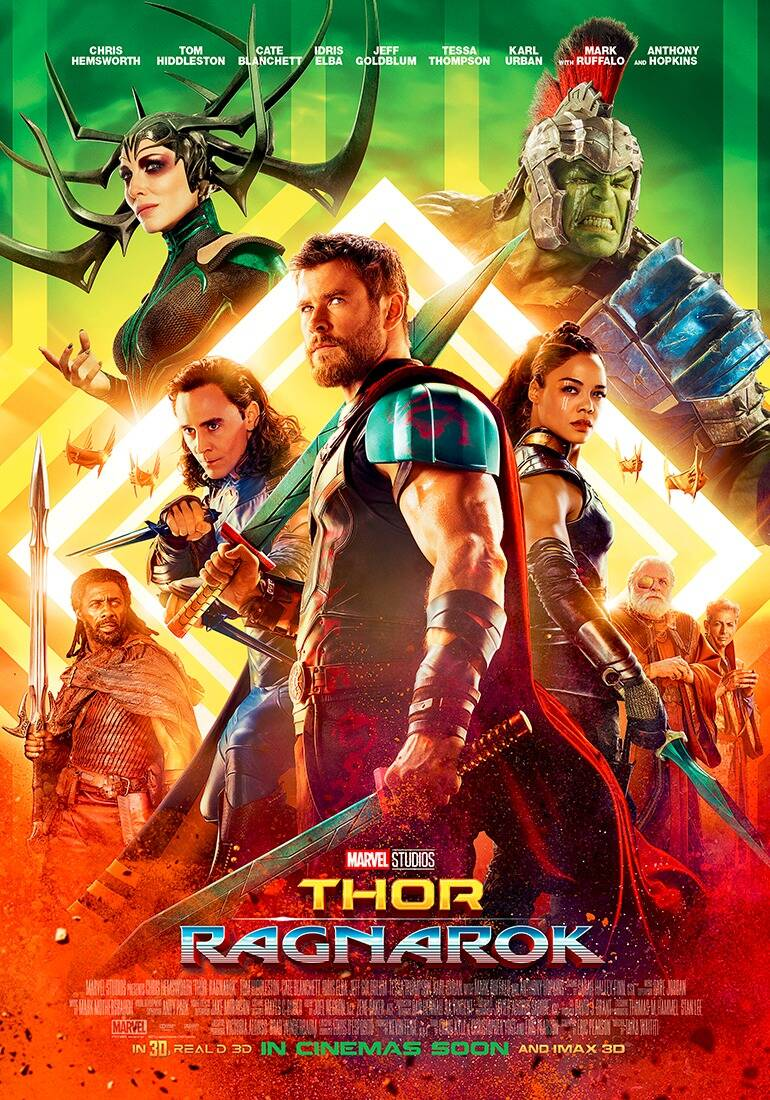

In [61]:
from ipywidgets import interact
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from PIL import Image

def plot_strip(strip, title='The Strip', w=100):
    """
    Plot a strip of color data
    
    :param strip: 2-D array, 2'nd dimension is color values
    :param title: Title of strip plot
    :param w: width of the plot of the strip
    """
    x, c = strip.shape
    strip_plot = strip.astype(np.uint8)
    strip_plot = np.reshape(strip_plot, (x, 1, c))
    strip_plot = np.broadcast_to(strip_plot, (x, w, c))
    plt.figure()
    plt.imshow(strip_plot)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def plot_colors(g, r, b, title='Color Values'):
    """
    Plot color values along 1d axis
    
    :param g: green color channel
    :param r: red color channel
    :param b: blue color channel
    """
    plt.figure()
    plt.plot(r, color='r', label='Red Channel')
    plt.plot(g, color='g', label='Green Channel')
    plt.plot(b, color='b', label='Blue Channel')
    plt.title(title)
    plt.xticks([])
    plt.legend()
    plt.show()

## The Game Plan

So my idea is to load the image into a numpy array, and then take an average of the colors across each row of the image. Since movie posters are vertical, my theory is that whatever gradient we'll find would be vertically aligned.

It sure works for this poster.

So once I have this strip of colors, I'll apply one or more gaussian filters to the strip to get a clean smooth gradient across the strip.

Then we can use that strip as our gradient, or do some more analysis to find the optimal javascript gradient code that would work for the image. Not sure how to do that, but we'll see...

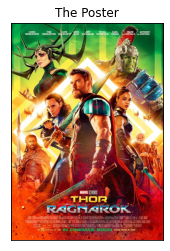

In [8]:
# Load image
image = Image.open('data/thor-ragnarok-poster.jpg')
imarr = np.asarray(image)

# Plot it ma dude
plt.figure()
plt.imshow(imarr)
plt.title('The Poster')
plt.xticks([])
plt.yticks([])
plt.show()

## Creating the Strip

The first thing to do is get the strip from the image. We do that by taking the mean over each row

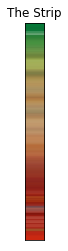

In [34]:
# Take mean over second axis
strip = np.mean(imarr, axis=1)
plot_strip(strip, 'The Strip')

So apparantly, there doesn't seem to be a need for multiple filters! We can actually do it with just one. Of course the filter width has to be set pretty wide for any effect to take place.

In [62]:
filtered = strip
@interact
def gaussian_filter(width=(1, 100, 1)):
    """
    Interactive single gaussian filter
    """
    global filtered
    
    # Do the gaussian filter
    filtered = gaussian_filter1d(strip, width, axis=0)
    plot_strip(filtered, 'Gaussian Filter')

interactive(children=(IntSlider(value=50, description='width', min=1), Output()), _dom_classes=('widget-intera…

So now the final thing I want to do is to brighten the colors, as the averaging definitely took some of the luster out of the color scale.

In [29]:
brightened = filtered
@interact
def brighten(value=(1, 2, 0.01)):
    """
    Interactive increase saturation
    """
    global brightened
    brightened = filtered * value
    brightened = np.clip(brightened, 0, 255)
    plot_strip(brightened, 'Brightened')

interactive(children=(FloatSlider(value=1.0, description='value', max=2.0, min=1.0, step=0.01), Output()), _do…

## Finding a Gradient Map

Now for the hard part. We need to find a set of n colors at x distances that can be properly interpolated between to create this color gradient. I don't want to do optimization, but I want to see if I can take this gradient and pull out the colors that make it up

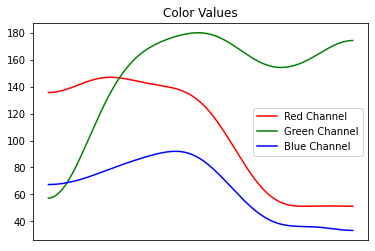

In [58]:
# We're gonna use the filtered strip (because the brightness is a bidirectional map)
fstrip = filtered

# Get red, green, and blue channels
g = fstrip[:,0]
r = fstrip[:,1]
b = fstrip[:,2]

# Plot colors
plot_colors(g, r, b)

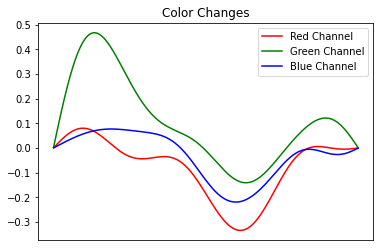

In [59]:
# Take derivatives?
gdiff = np.diff(g)
rdiff = np.diff(r)
bdiff = np.diff(b)
plot_colors(gdiff, rdiff, bdiff, title='Color Changes')